In [168]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from tensorflow import keras
from tensorflow.keras import layers

In [169]:
print(f"Total of images in test folder: {len(os.listdir('data/test/child')) + len(os.listdir('data/test/adult'))}")
print(f"\nTotal of images in train folder: {len(os.listdir('data/train/child')) + len(os.listdir('data/train/adult'))}")
print(f"\nTotal of images in validation folder: {len(os.listdir('data/val/child')) + len(os.listdir('data/val/adult'))}")

Total of images in test folder: 209

Total of images in train folder: 668

Total of images in validation folder: 167


In [170]:
# Importing necessary packages

import tensorflow as tf
from tensorflow import keras

In [171]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an instance of the ImageDataGenerator class with data augmentation parameters
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

# Load the images from the directory and apply data augmentation
train_generator = train_datagen.flow_from_directory(
        'data/train',
        classes=['child', 'adult'],
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

# Load the validation and test sets without data augmentation
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = valid_datagen.flow_from_directory(
        'data/val',
        classes=['child', 'adult'],
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

test_generator = test_datagen.flow_from_directory(
        'data/test',
        classes=['child', 'adult'],
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')


Found 668 images belonging to 2 classes.
Found 167 images belonging to 2 classes.
Found 209 images belonging to 2 classes.


## 4) CNN architecture

In [172]:
# Import necessary packages
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

def build_model(print_summary=False):
    # Creating a sequential model
    model = Sequential()

    # Add a convolutional layer with 32 filters and 3x3 kernel size
    model.add(layers.Conv2D(32, (3, 3), activation="relu", input_shape=(150, 150, 3)))

    # Add a max pooling layer with 2x2 pool size
    model.add(layers.MaxPooling2D((2, 2)))

    # Add another convolutional layer with 64 filters and 3x3 kernel size
    model.add(layers.Conv2D(64, (3, 3), activation="relu"))

    # Add another max pooling layer with 2x2 pool size
    model.add(layers.MaxPooling2D((2, 2)))

    # Add a flatten layer to convert the feature maps into a one-dimensional vector
    model.add(layers.Flatten())

    # Add a dense layer with 64 units and relu activation
    model.add(layers.Dense(64, activation="relu"))

    # Add a dropout layer with 0.5 probability to reduce overfitting
    model.add(layers.Dropout(0.5))

    # Add an output layer with one unit and sigmoid activation for binary classification
    model.add(layers.Dense(1, activation="sigmoid"))
    
    # display summary is optional
    if print_summary:
        model.summary()
    return model

model = build_model(print_summary=True)



Model: "sequential_72"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_144 (Conv2D)         (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_144 (MaxPooli  (None, 74, 74, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_145 (Conv2D)         (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_145 (MaxPooli  (None, 36, 36, 64)       0         
 ng2D)                                                           
                                                                 
 flatten_72 (Flatten)        (None, 82944)             0         
                                                                 
 dense_144 (Dense)           (None, 64)              

In [173]:
learning_rates = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6]

In [174]:
from keras.optimizers import Adam

opt = Adam(lr=1e-4)

# Compile the model

def compile_model(model, lr):
    opt = Adam(lr=lr)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'], run_eagerly=True)
    return model

model = compile_model(model, lr=1e-4)

c:\Users\franc\anaconda3\envs\tf\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [175]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Define the callbacks
checkpoint = ModelCheckpoint('model.h5', monitor='val_loss', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

In [176]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

histories = [] # for plotting val_loss vs epochs for each learning rate
best_val_losses = [] # for plotting best_val_loss vs learning rate
best_val_accs = []

for lr in learning_rates:
    print('Training with: ', lr)
    model = build_model()
    model = compile_model(model, lr=lr)

    # Train the model with early stopping #
    H = model.fit(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=17,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        callbacks=[checkpoint, early_stopping],
        verbose=1)

    best_loss = model.evaluate(test_generator, steps=len(test_generator))
    best_val_losses.append(best_loss)

    
    histories.append(H)

Training with:  0.01
Epoch 1/17
21/21 [==============================] - 3s 140ms/step - loss: 4.1178 - accuracy: 0.5225 - val_loss: 0.6931 - val_accuracy: 0.5030
Epoch 2/17
21/21 [==============================] - 3s 141ms/step - loss: 0.6939 - accuracy: 0.4955 - val_loss: 0.6932 - val_accuracy: 0.5030
Epoch 3/17
21/21 [==============================] - 3s 142ms/step - loss: 0.6937 - accuracy: 0.4910 - val_loss: 0.6931 - val_accuracy: 0.5030
Epoch 4/17
21/21 [==============================] - 3s 125ms/step - loss: 0.6931 - accuracy: 0.5090 - val_loss: 0.6932 - val_accuracy: 0.4970
Epoch 5/17
21/21 [==============================] - 3s 140ms/step - loss: 0.6930 - accuracy: 0.5060 - val_loss: 0.6932 - val_accuracy: 0.4970
Epoch 6/17
21/21 [==============================] - 3s 152ms/step - loss: 0.6936 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5030
Epoch 7/17
21/21 [==============================] - 3s 143ms/step - loss: 0.6935 - accuracy: 0.4790 - val_loss: 0.6932 - val_ac

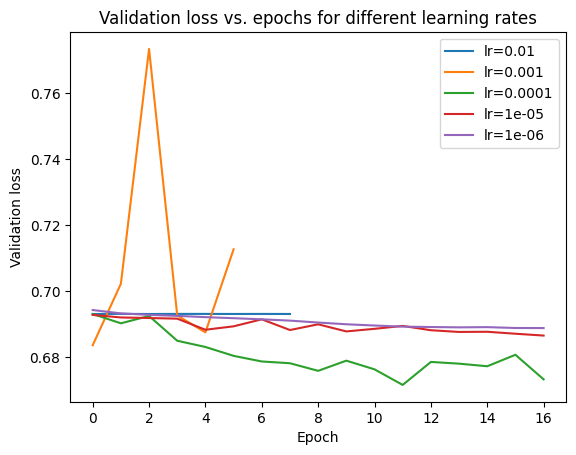

In [177]:
# Plot validation loss vs. epochs for each learning rate 

for i, H in enumerate(histories):
    plt.plot(H.history['val_loss'], label=f'lr={learning_rates[i]}')
plt.title('Validation loss vs. epochs for different learning rates')
plt.xlabel('Epoch')
plt.ylabel('Validation loss')
plt.legend()
plt.show()

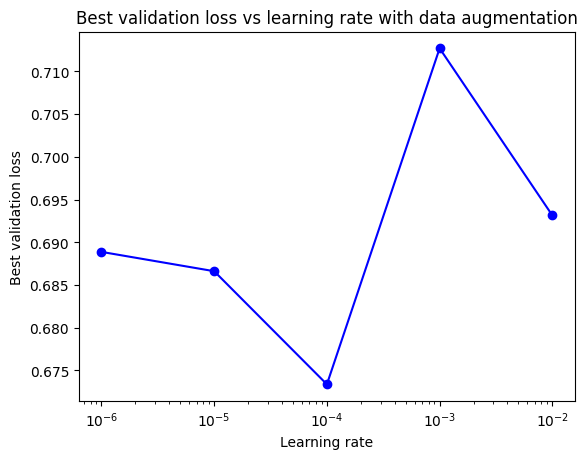

In [178]:
# Plot best validation loss vs learning rate
best_val_loss = []
for i, H in enumerate(histories):
    val_loss = H.history['val_loss'][-1]  # take the last value of val_loss
    best_val_loss.append(val_loss)

plt.plot(learning_rates, best_val_loss, 'bo-')
plt.title('Best validation loss vs learning rate with data augmentation')
plt.xlabel('Learning rate')
plt.ylabel('Best validation loss')
plt.xscale('log')
plt.show()

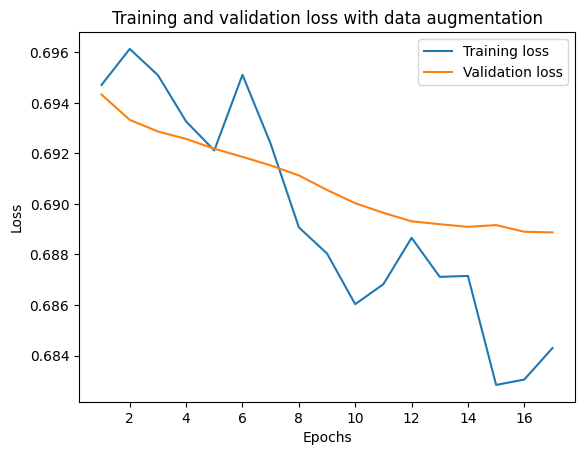

In [179]:
def loss_plotter(H):
    loss = H.history['loss']
    val_loss = H.history['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, label='Training loss')
    plt.plot(epochs, val_loss, label='Validation loss')
    plt.title('Training and validation loss with data augmentation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
 

loss_plotter(H)

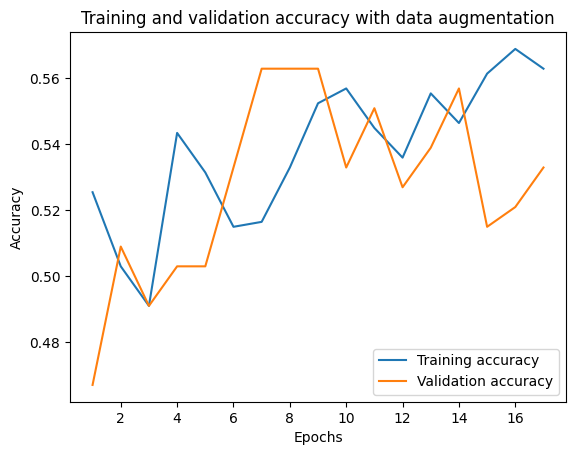

In [180]:
def accuracy_plotter(H):
    acc = H.history['accuracy']
    val_acc = H.history['val_accuracy']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, label='Training accuracy')
    plt.plot(epochs, val_acc, label='Validation accuracy')
    plt.title('Training and validation accuracy with data augmentation')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    
accuracy_plotter(H)

In [181]:
# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(test_generator, steps=len(test_generator))
print('Test accuracy:', test_acc)

7/7 [==============================] - 0s 44ms/step - loss: 0.6924 - accuracy: 0.5072
Test accuracy: 0.5071770548820496


In [182]:
best_val_accuracy = max(H.history['val_accuracy'])
best_val_accuracy

0.5628742575645447